In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

sns.set_theme(style="darkgrid")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Exploratory Data Analysis

In [2]:
data = pd.read_csv('examples/LeadScoring/bank-additional-full.csv')

df = data.copy()
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
29222,34,housemaid,divorced,university.degree,no,unknown,unknown,cellular,apr,fri,...,2,999,1,failure,-1.8,93.075,-47.1,1.405,5099.1,no
14240,27,blue-collar,single,basic.9y,no,unknown,unknown,cellular,jul,mon,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
19727,34,technician,single,university.degree,no,yes,no,cellular,aug,thu,...,4,999,0,nonexistent,1.4,93.444,-36.1,4.968,5228.1,no
22343,29,admin.,single,university.degree,no,yes,no,cellular,aug,thu,...,3,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
10696,37,services,divorced,high.school,no,yes,no,telephone,jun,tue,...,4,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
# --------------------------------------------
# Dropping 'duration' from analysis
# Duration of call is uknown when converting
# Avoids data leakage
#

df = df.drop(columns='duration')

In [5]:
# --------------------------------------------
# Changing column names for better interpretability
#

col_name_change = {
    'job' : 'job_category',
    'marital' : 'marital_status',
    'default' : 'history_of_default',
    'housing' : 'has_housing_loan',
    'loan' : 'has_personal_loan',
    'contact' : 'contact_type',
    'month' : 'month_of_last_contact',
    'day_of_week' : 'dayofweek_of_last_contact',
    'campaign' : 'no_of_previous_campaigns',
    'pdays' : 'days_since_last_contact',
    'previous' : 'number_of_times_contacted',
    'poutcome' : 'outcome_of_previous_campaign',
    'y' : 'conversion'
}

df = df.rename(columns=col_name_change)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           41188 non-null  int64  
 1   job_category                  41188 non-null  object 
 2   marital_status                41188 non-null  object 
 3   education                     41188 non-null  object 
 4   history_of_default            41188 non-null  object 
 5   has_housing_loan              41188 non-null  object 
 6   has_personal_loan             41188 non-null  object 
 7   contact_type                  41188 non-null  object 
 8   month_of_last_contact         41188 non-null  object 
 9   dayofweek_of_last_contact     41188 non-null  object 
 10  no_of_previous_campaigns      41188 non-null  int64  
 11  days_since_last_contact       41188 non-null  int64  
 12  number_of_times_contacted     41188 non-null  int64  
 13  o

In [45]:
df.describe()

,age,no_of_previous_campaigns,days_since_last_contact,number_of_times_contacted,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [43]:
df[['age', 'conversion']]

,age,conversion
0,56,no
1,57,no
2,37,no
3,40,no
4,56,no
...,...,...
41183,73,yes
41184,46,no
41185,56,no
41186,44,yes


<Figure size 640x480 with 0 Axes>

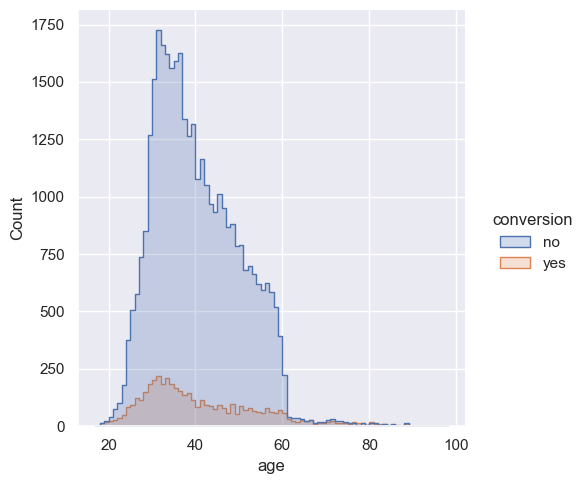

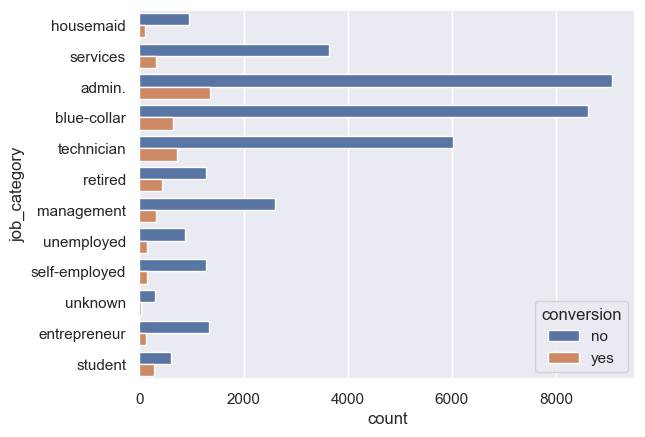

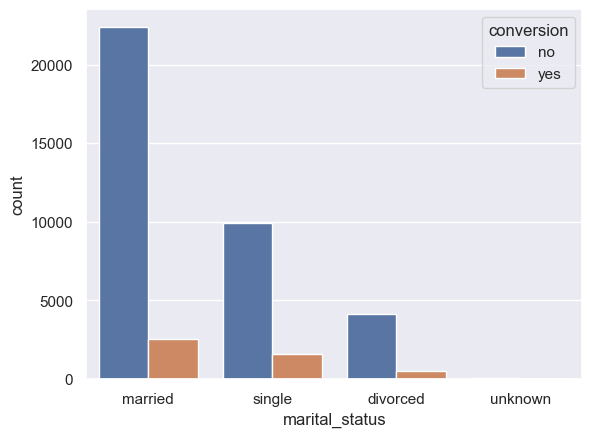

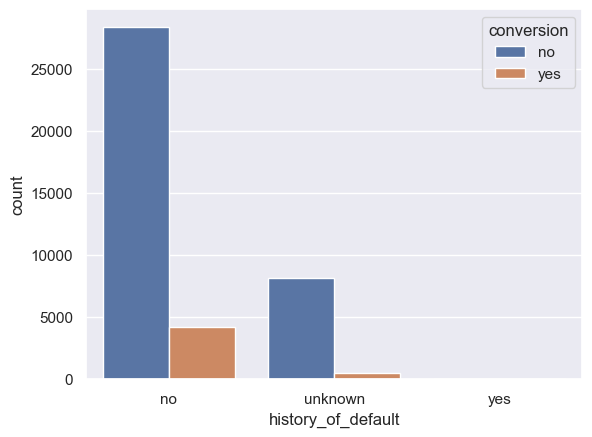

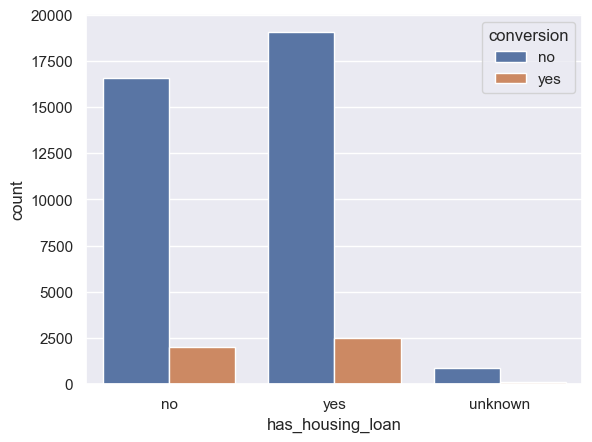

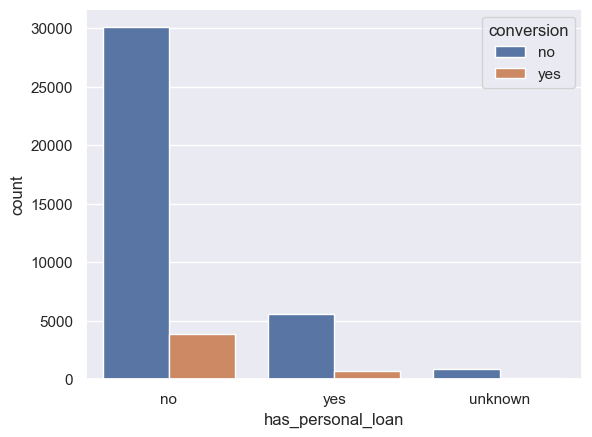

In [54]:
#
# Customer Info
#

customer_info = ['age', 'job_category', 'marital_status', 'history_of_default',
                 'has_housing_loan', 'has_personal_loan']

nrows=int(len(customer_info)/2)

index=1
for i in customer_info:
    plt.figure()
    if is_numeric_dtype(df[i]):
        bins = int((max(df[i]) - min(df[i])))
        sns.displot(data=df, x=i, hue="conversion", bins=bins, element="step")
    elif len(df[i].unique()) > 4:
        sns.countplot(data=df, y=i, hue="conversion")
    else:    
        sns.countplot(data=df, x=i, hue="conversion")

### Feature Engineering

### Model & Evaluation